# Trajectory generation 

From the path planning module you learned how to obtain waypoints that connect the initial and the goal locations. But we need to be able to calculate the target position at some *arbitrary* time $t$. So we need a way to convert **discrete** waypoints into a **continuous** path.  

### Line segmentation 

Let's start with a one-dimensional example where we only know the $x$ position in time. Additionally, we want the drone to change position at constant speed. The task is to use the position $x$ and time $t$ **arrays** and provide the position and velocity value to the drone's controller at any time instance. 


<img src="OneD2.png" width="450">

For any desired time $t_{now}$ let us first find the line segment associated with the given time - the segment for which $t_i<t_{now}<t_{i+1}$. The goal is to fly the drone between two positions $P_i$ and $P_{i+1}$ with the constant velocity which will bring the drone from point $x_i$ and time $t_i$ into point $x_{i+1}$ at time $t_{i+1}$.

In order to guide the drone controller to execute the given flight, we will provide the target position $x_{target}$ and velocity $v_{target}$ at $t_{now}$.

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import jdc

np.set_printoptions(precision=3)
pylab.rcParams['figure.figsize'] = 10, 10

Determining which segment the drone should be at given $t_{now}$. The input parameters include $t$ vector for each waypoint from initial til the last one and $t_{now}$ relative to which we need to determine the segment on which the drone is. 

In [2]:
def line_segment(t,    # Array of times for each position
                 t_now # Current time (float)
                ):
    """
    Returns the start and end index corresponding to the line
    segment in which t_now occurs.
    """
    i = np.argwhere(t>t_now)
    if len(i)>0: 
        if i[0]!=0: # if the current time is not less than the starting time 
            segment_starting_index = i[0][0]-1
        else: 
            segment_starting_index = 0

        segment_end_index = i[0][0]
        
    else: # if the current time is more than the last point (destination) time
        segment_starting_index = t.shape[0]
        segment_end_index = t.shape[0]
    
    return segment_starting_index, segment_end_index

In [3]:
#     index:  0    1    2    3    4
t = np.array([1.2, 3.4, 5.7, 6.2, 7.9])

t_now = 4.1 # this is between index 1 and 2

line_segment(t, t_now)

(1, 2)

Now that we know how to find the starting and end index of the segment on which the drone needs to be we can find the desired position and velocity. Keep in mind that in this exercise we are assuming that we want the drone to have a constant speed along the entire segment between $x_i$ and $x_{i+1}$.

In [4]:
def commanded_values(x,     # Array of x positions 
                     t,     # Array of times for each position
                     t_now, # Current time 
                     segment_starting_index, 
                     segment_end_index
                     ):
    
    start_x = x[segment_starting_index]
    end_x   = x[segment_end_index]
    delta_x = end_x - start_x
    
    start_t = t[segment_starting_index]
    end_t   = t[segment_end_index]
    delta_t = end_t - start_t
    
    v     = delta_x / delta_t
    x_now = start_x + v * (t_now - start_t)
             
    return np.array([x_now, v])

In [5]:
# example usage

x = np.array([0,   1,   3,   6,   10])
t = np.array([1.2, 3.4, 5.7, 6.2, 7.9])

t_now = 2.3 # directly between t[0] and t[1]

start, end = line_segment(t, t_now)

commanded_values(x,t,t_now, start, end)

array([ 0.5  ,  0.455])

### Defining the parameters
We will use the periodic trajectory which is given every second and connected by straight lines $x = \sin{\omega_x t}$.

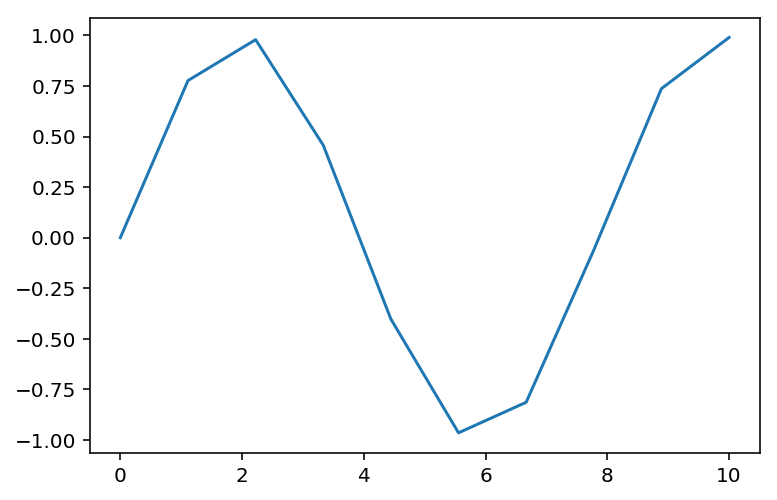

In [6]:
t = np.linspace(0,10,10)
x = np.zeros(t.shape)

omega_x = 0.8
x = np.sin(omega_x*t)
plt.plot(t,x)
plt.show()

Calculating the desired position and velocity for a given time $t_{now} = 2.8$. 

In [7]:
t_now = 2.8

segment_starting_index, segment_end_index = line_segment(t,t_now)

target_parameters = commanded_values(x,
                                     t,
                                     t_now,
                                     segment_starting_index,
                                     segment_end_index)


print('Target position and velocity ',target_parameters)

Target position and velocity  [ 0.708 -0.469]


Plotting the path with the current position.

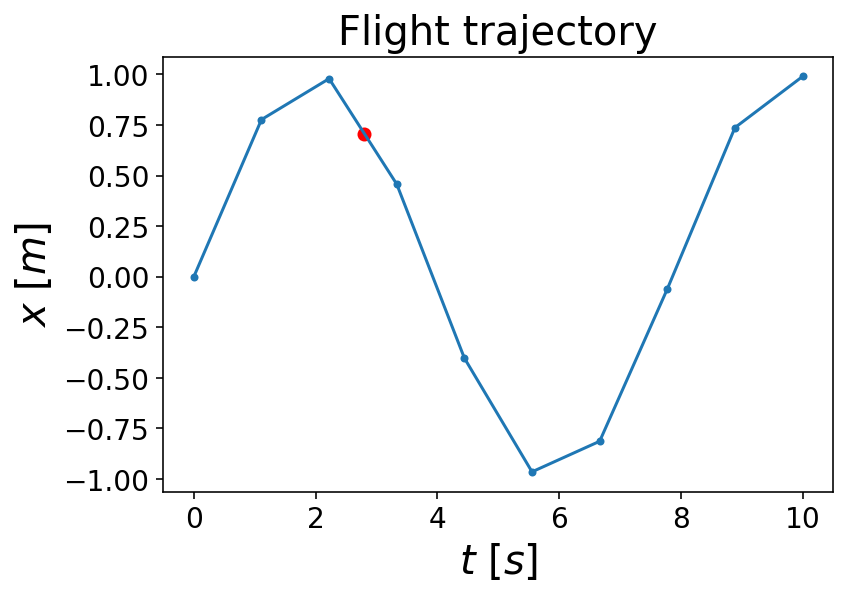

In [8]:
plt.plot(t,x,marker='.')
plt.scatter(t_now,target_parameters[0],marker='o',color='red')
plt.title('Flight trajectory').set_fontsize(20)
plt.xlabel('$t$ [$s$]').set_fontsize(20)
plt.ylabel('$x$ [$m$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

# Generalizing into 3D

Now that we know how to find the target position and velocity at any time in one dimension we can do the same for a full three-dimensional trajectory.

We would like to fly the drone in a line connecting two waypoints $P_i$ and $P_{i+1}$ with a velocity which will bring the drone from point $(x_i,y_i,z_i)$ and time $t_i$ to point $(x_{i+1},y_{i+1},z_{i+1})$ at time $t_{i+1}$. Also we will impose the additional condition that the drone needs to be facing toward the goal position. 

Similarly for any desired time $t_{now}$ we will calculate the line segment associated with the given time. If $t_{now}$ is less than $t_0$ then the drone should not be moving and if $t_{now}$ is more than $t_{last}$ then the drone should not be moving as well. In all other cases, the drone should be on the segment of the trajectory between $i$ and $i+1$.

Now that we know how to obtain the starting and end index of the segment on which the drone needs to be we can obtain the desired position, velocity and yaw. 

**Note** if the drone is moving vertically up or down the yaw value is not important. It can be left unchanged from the previous values.

For the three dimensional description we will replace $x$ variable with $p$ which will contain all three elements of the point $p_i=(x_i,y_i,z_i)$

In [9]:
def commanded_values_3d(p,     # Array of points
                        t,     # Array of time 
                        t_now, # Current time 
                        segment_starting_index,
                        segment_end_index,
                        previous_psi):
    
    x = p[0,:]
    y = p[1,:]
    z = p[2,:] 
    
    # calculating the velocities 
    v_x_now = (x[segment_end_index] - x[segment_starting_index]) \
            / (t[segment_end_index] - t[segment_starting_index])
    v_y_now = (y[segment_end_index] - y[segment_starting_index]) \
            / (t[segment_end_index] - t[segment_starting_index])
    v_z_now = (z[segment_end_index] - z[segment_starting_index]) \
            / (t[segment_end_index] - t[segment_starting_index])
    
    # calculating the position
    x_now = x[segment_starting_index] + v_x_now * (t_now - t[segment_starting_index])
    
    y_now = y[segment_starting_index] + v_y_now * (t_now - t[segment_starting_index])
            
    z_now = z[segment_starting_index] + v_z_now * (t_now - t[segment_starting_index])
    
    # If drone does not move vertically up. 
    if x[segment_end_index]!=x[segment_starting_index] and \
       y[segment_end_index]!=y[segment_starting_index]:
        
        psi_now = np.arctan2((y[segment_end_index] - y[segment_starting_index]),
                             (x[segment_end_index] - x[segment_starting_index]))
    else:
        psi_now = previous_psi
                           
    return np.array([x_now, y_now, z_now, v_x_now, v_y_now, v_z_now, psi_now])

### Defining the parameters
We will use the familiar three-dimensional trajectory that consists of periodic functions. 
$$
\begin{align}
x &= \sin{\omega_x t} \\
y &= \cos{\omega_y t} \\
z &= \cos{\omega_z t} \\
\end{align}
$$
$\omega_z = \omega_y = \omega_x/2$. But will discretize them for each second, resulting in the discontinious path. 

In [10]:
t = np.linspace(0,10,10)
p = np.zeros((3,t.shape[0]))

omega_x = 0.8
omega_y = 0.4
omega_z = 0.4
x_amp = 1.0
y_amp = 1.0
z_amp = 1.0

p[0,:] = x_amp*np.sin(omega_x*t)
p[1,:] = y_amp*np.cos(omega_y*t)
p[2,:] = z_amp*np.cos(omega_z*t)

Calculating the desired position, velocity and yaw for a given time $t_{now} = 2.8$. 

In [11]:
t_now = 2.8
previous_psi = 0

segment_starting_index, segment_end_index = line_segment(t,t_now)

target_parameters = commanded_values_3d(p,
                                       t,
                                       t_now,
                                       segment_starting_index,
                                       segment_end_index,
                                       previous_psi)

print('Target location (x, y, z) =', target_parameters[0:3])
print('Target velocities (v_x, v_y, v_z) = ', target_parameters[3:6])
print('Target yaw angle %5.3f'%target_parameters[6])

Target location (x, y, z) = [ 0.708  0.425  0.425]
Target velocities (v_x, v_y, v_z) =  [-0.469 -0.356 -0.356]
Target yaw angle -2.493


Plotting the flight path with the current position, velocity and yaw.

In [13]:
plt.rcParams['figure.figsize'] = 15, 15

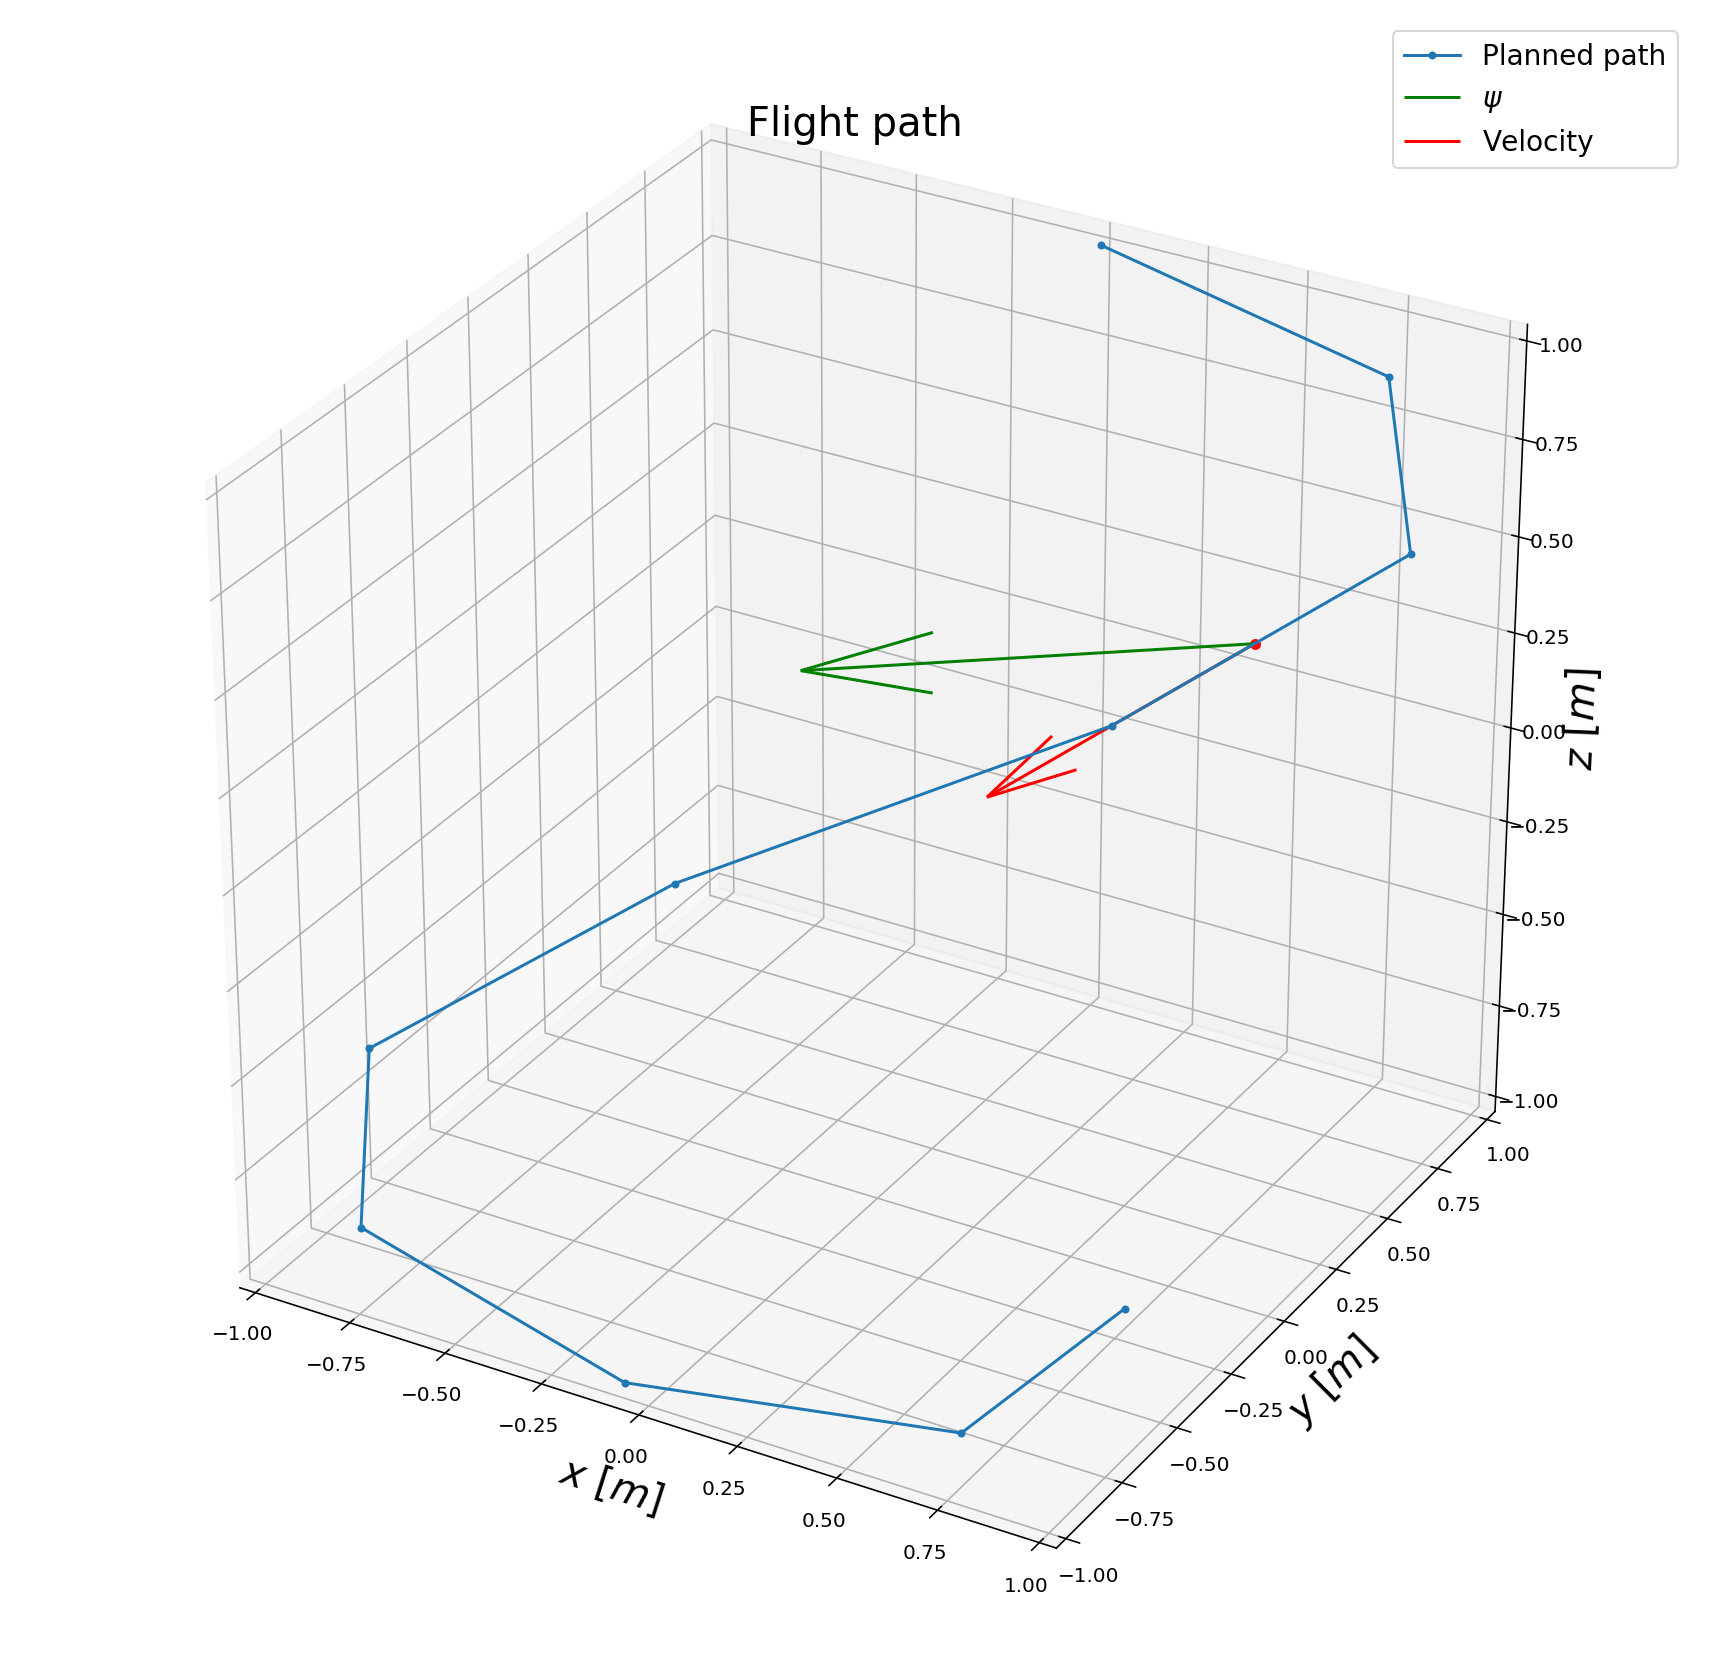

In [14]:
x_path=p[0,:]
y_path=p[1,:]
z_path=p[2,:]

x_now = target_parameters[0] 
y_now = target_parameters[1] 
z_now = target_parameters[2] 

v_x_now = target_parameters[3] 
v_y_now = target_parameters[4] 
v_z_now = target_parameters[5] 

psi_now = target_parameters[6] 

u = np.cos(psi_now) 
v = np.sin(psi_now) 
w = 0
    
fig = plt.figure() 
ax = fig.gca(projection='3d')

ax.plot(x_path, y_path, z_path, marker ='.')
ax.quiver(x_now, y_now, z_now, u, v, w, length=1.0, normalize=True,color='green')
ax.quiver(x_now, y_now, z_now, v_x_now, v_y_now, v_z_now,color='Red')
ax.scatter(x_now, y_now, z_now, marker ='o',color='red')

plt.title('Flight path').set_fontsize(20)
ax.set_xlabel('$x$ [$m$]').set_fontsize(20)
ax.set_ylabel('$y$ [$m$]').set_fontsize(20)
ax.set_zlabel('$z$ [$m$]').set_fontsize(20)
plt.legend(['Planned path','$\psi$','Velocity'],fontsize = 14)
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.set_zlim(-1.0, 1.0)
plt.show()

This is a naive approach to waypoint smoothing and it results in trajectories which aren't actually feasible. But this is very similar to the code you will see in the Python portion of the final project in a function called `trajectory_control`.